## Solar System Barycenter Calculations
#### Notebook by Lavender Elle Hanson

In [1]:
%matplotlib widget
import spiceypy as sp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, transforms
import pandas as pd
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100
plt.rcParams["animation.embed_limit"] = 100

### Calculation parameters

In [2]:
# set time range
t0, t1 = "1950-01-01T00:00", "2050-01-01T00:00"
t0, t1 = "1800-01-01T00:00", "2200-01-01T00:00"
# number of intervals
NL = 1200
# animate or not
animate = True
save_animation = False
FRAME_RATE = 15
# show uranus/neptune or not
SHOW_URANUS = True
SHOW_NEPTUNE = True

### Load SPICE ephemeris data

In [3]:
from os import path
from urllib.request import urlretrieve

# list of spice kernels
ephem_urls = (
    "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/latest_leapseconds.tls",
    "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440.bsp",
    # "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/pck00011.tpc",
)
sp.kclear()
_downloaded_kernels = []

# load spice data
for url in ephem_urls:
    name = path.basename(url)
    if not path.exists(name):
        urlretrieve(url, name)
        _downloaded_kernels += [name]
    sp.furnsh(name)

# provide cleanup function
def cleanup():
    from os import unlink
    for name in _downloaded_kernels:
        unlink(name)

### Calculate barycenter locations

In [4]:
# et0, et1 = sp.str2et("1900-01-01T00:00"), sp.str2et("2100-01-01T00:00")
YEAR = 31557600 # seconds per year
RSUN = 695700 # [km]
et0, et1 = sp.str2et(t0), sp.str2et(t1)
xyz = np.zeros((NL, 3))
xyz_sat = np.zeros((NL, 3))
xyz_jup = np.zeros((NL, 3))
xyz_ura = np.zeros((NL, 3))
xyz_nep = np.zeros((NL, 3))
tt = np.linspace(et0, et1, NL)
tlist = []
for ix, et in enumerate(tt):
    xyz[ix,:], _ = sp.spkpos("SOLAR SYSTEM BARYCENTER", et, "J2000", "NONE", "SUN")
    xyz_sat[ix,:], _ = sp.spkpos("SATURN BARYCENTER", et, "J2000", "NONE", "SUN")
    xyz_jup[ix,:], _ = sp.spkpos("JUPITER BARYCENTER", et, "J2000", "NONE", "SUN")
    xyz_ura[ix,:], _ = sp.spkpos("URANUS BARYCENTER", et, "J2000", "NONE", "SUN")
    xyz_nep[ix,:], _ = sp.spkpos("NEPTUNE BARYCENTER", et, "J2000", "NONE", "SUN")
    tlist.append(sp.et2utc(et, "C", 0))
def mag(x, axis=-1):
    return np.sqrt(np.sum(x**2, axis=axis, keepdims=True))
def norm(x, axis=-1):
    return x/mag(x)

### Plot barycenter position (and calculate distance from Sun's center)

Barycenter < 0.5 Rsun: 6.67%.
Barycenter < 1 Rsun: 38.25%.
Barycenter < 2 Rsun: 97.25%.


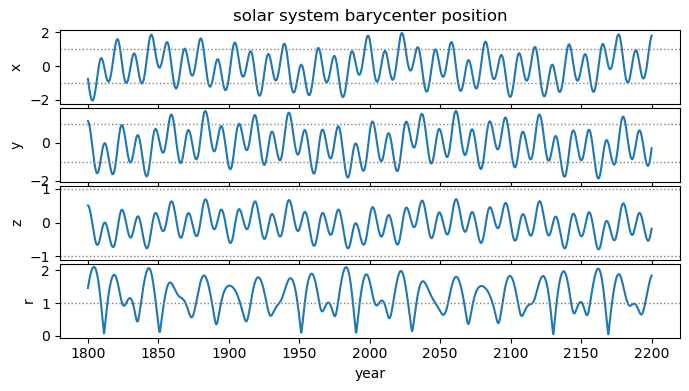

In [5]:
plt.ioff()
plt.close("all")
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8,4),
                        gridspec_kw=dict(hspace=0.05))
for ix, axis in enumerate("xyz"):
    axs[ix].plot(tt/YEAR+2000, xyz[:,ix]/RSUN, )
    axs[ix].axhline(1, linestyle=":", linewidth=1, color="gray")
    axs[ix].axhline(-1, linestyle=":", linewidth=1, color="gray")
    axs[ix].set_ylabel(axis)
axs[3].plot(tt/YEAR+2000, mag(xyz)/RSUN)
axs[3].axhline(1, linestyle=":", linewidth=1, color="gray")
axs[3].set_ylabel("r")
axs[3].set_xlabel("year")
axs[3].yaxis.set_ticks([0,1,2])
axs[0].set_title("solar system barycenter position")
# axs[0].set_xlim((tt/YEAR+2000).min(), (tt/YEAR+2000).max())
in_sun = (mag(xyz) < RSUN).sum()/len(xyz)*100
in_halfsun = (mag(xyz) < RSUN/2).sum()/len(xyz)*100
in_2sun = (mag(xyz) < 2*RSUN).sum()/len(xyz)*100
print(f"Barycenter < 0.5 Rsun: {in_halfsun:0.2f}%.")
print(f"Barycenter < 1 Rsun: {in_sun:0.2f}%.")
print(f"Barycenter < 2 Rsun: {in_2sun:0.2f}%.")
fig.savefig("barycenter-400.png")
fig

### Make animated plot of X-Y position

In [ ]:
from matplotlib.transforms import Affine2D
plt.close("all")
plt.ion()
if animate:
    plt.ioff()

# figure parameters
awidth = 0.02
PTMAX = min(NL//3, 50)
finterval = 1000/FRAME_RATE

# make figure
fig, ax = plt.subplots()

# label title, axes
ax.set_title("solar system barycenter")
ax.set_xlabel("x, J2000 [R$_{\odot}$]")
ax.set_ylabel("y, J2000 [R$_{\odot}$]")

# show solar radius
ax.add_artist(plt.Circle((0,0), 1, edgecolor="black", linestyle="-",
                                linewidth=1, facecolor="none"))

# display date of current barycenter point
tdate = ax.text(0.02, 0.98, tlist[0], transform=ax.transAxes, 
                verticalalignment="top", fontsize="small")

# plot past and current barycenters
pts, = ax.plot(xyz[:1,0]/RSUN, xyz[:1,1]/RSUN, #color="gray",
            marker="+", markersize=3, color="pink",
            linestyle="--", linewidth=0.5,
            alpha=0.7)
pnow, = ax.plot(*xyz[0,:2]/RSUN, marker="x", color="red")

# SATURN
sarrow = ax.arrow(0.5, 0, 0.5, 0, linestyle="-", color="orange", length_includes_head=True, width=awidth, 
                  transform=ax.transData)
sanno = ax.text(0.4, 0, "S", fontweight="bold", ha="center", va="center", 
                transform_rotates_text=False, transform=ax.transData)
# psat, = ax.plot(*s, "sr")
def update_saturn(ix):
    s = norm(xyz_sat[ix,:])[:2]
    transSaturn = Affine2D().rotate_around(0,0,np.arctan2(*s[::-1]))
    sanno.set_transform(transSaturn + ax.transData)
    sarrow.set_transform(transSaturn + ax.transData)
    # psat.set_data(*s)
    return [sanno, sarrow] #, psat]

# JUPITER
jarrow = ax.arrow(0.5, 0, 0.5, 0, linestyle="-", color="red", length_includes_head=True, width=awidth, 
                  transform=ax.transData)
janno = ax.text(0.4, 0, "J", fontweight="bold", ha="center", va="center",
                transform_rotates_text=False, transform=ax.transData)
# pjup, = ax.plot(*j, "sb")
def update_jupiter(ix):
    j = norm(xyz_jup[ix,:])[:2]
    transJupiter = Affine2D().rotate_around(0,0,np.arctan2(*j[::-1]))
    janno.set_transform(transJupiter + ax.transData)
    jarrow.set_transform(transJupiter + ax.transData)
    # pjup.set_data(*j)
    return [janno, jarrow] #, pjup]

# URANUS
if SHOW_URANUS:
    uarrow = ax.arrow(0.5, 0, 0.5, 0, linestyle="-", color="darkcyan", length_includes_head=True, width=awidth, 
                      transform=ax.transData)
    uanno = ax.text(0.4, 0, "U", fontweight="bold", ha="center", va="center",
                    transform_rotates_text=False, transform=ax.transData)
def update_uranus(ix):
    if SHOW_URANUS:
        u = norm(xyz_ura[ix,:])[:2]
        transUranus = Affine2D().rotate_around(0,0,np.arctan2(*u[::-1]))
        uanno.set_transform(transUranus + ax.transData)
        uarrow.set_transform(transUranus + ax.transData)
        # pura.set_data(*j)
        return [uanno, uarrow] #, pura]
    return []

# NEPTUNE
if SHOW_NEPTUNE:
    narrow = ax.arrow(0.5, 0, 0.5, 0, linestyle="-", color="blue", length_includes_head=True, width=awidth, 
                      transform=ax.transData)
    nanno = ax.text(0.4, 0, "N", fontweight="bold", #color="darkblue",
                    ha="center", va="center",
                    transform_rotates_text=False, transform=ax.transData)
def update_neptune(ix):
    if SHOW_NEPTUNE:
        n = norm(xyz_nep[ix,:])[:2]
        transNeptune = Affine2D().rotate_around(0,0,np.arctan2(*n[::-1]))
        nanno.set_transform(transNeptune + ax.transData)
        narrow.set_transform(transNeptune + ax.transData)
        # pnep.set_data(*j)
        return [nanno, narrow] #, pnep]
    return []

# set axis limits
plt.axis("square")
plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)

# frame update function
def draw_frame(ix):
    r = [tdate.set_text(tlist[ix])]
    r += update_saturn(ix)
    r += update_jupiter(ix)
    r += update_uranus(ix)
    r += update_neptune(ix)
    pts.set_data(*xyz[:ix,:2].T/RSUN)
    if ix > PTMAX:
        pts.set_data(*xyz[ix-PTMAX:ix,:2].T/RSUN)
    pnow.set_data(*xyz[ix-1, :2]/RSUN)
    r += [pts, pnow]
    return tuple(r)
draw_frame(1)

# animate plot
anim = fig
if animate:
    anim = animation.FuncAnimation(
        fig, draw_frame, blit=True, init_func=lambda:draw_frame(0), frames=NL, 
        interval=finterval, repeat_delay=300, repeat=True
    )
    if save_animation:
        anim.save("barycenter.html", writer="html")
anim

### Save animation as gif

In [7]:
anim.save("barycenter.gif", writer="pillow")